# Evolutionary algorithm experiments

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import logging
import random

from constants import PATH_PURE_COMPONENTS, PATH_MIXTURES, X
from file_io import load_pickle_file
from solvers.common import *
from solvers.correction_models import *

from numpy.random import normal

logging.basicConfig(level=logging.INFO)

In [3]:
logger = logging.getLogger(__name__)

## Load data

In [4]:
pure_components = load_pickle_file(PATH_PURE_COMPONENTS)
mixtures_data = load_pickle_file(PATH_MIXTURES)

## Analysis

### Constants

In [5]:
N_POPULATION = 200
N_SURVIVORS = 30
N_LINEAR_COMBINATIONS = 30
N_MUTATIONS = 100
INIT_GUESS = [0, 0, 0]
INIT_DEVIATIONS = [0.01, 0.1, 1]
N_MAX_GENERATIONS = 300
RSME_THRESHOLD = 2
N_STEADY_THRESHOLD = 50
MAX_X_DEVIATION = 50

In [6]:
correction_model = quadratic_correction
x_original = X
signal = mixtures_data[0]['signal']
true = mixtures_data[0]['contributions']

### Optimization

In [7]:
correction_model = quadratic_correction
n_population: int = 50
n_survivors: int = None
n_crossovers: int = None
n_mutations: int = None
init_guess: Tuple[float] = (0, 0, 0)
deviations: Tuple[float] = (0.01, 0.1, 1)
deviations_scaling: Tuple[float] = None
n_max_generations: int = 500
rsme_threshold: float = 1
n_no_change_threshold: int = 50
max_x_deviation: float = None
scaled_proportion = 0.7

In [8]:
all_rsme_values = []

In [9]:
# Initialize optional arguments if not given
if not max_x_deviation:
    max_x_deviation = (max(x_original) - min(x_original)) // 2
if not deviations_scaling:
    deviations_scaling = np.array([1 / k for k in range(1, n_max_generations + 1)])

# Initialize parameter candidates
parameters = []
for _ in range(n_population):
    candidate = [normal(loc=mean, scale=stdev) for mean, stdev in zip(init_guess, deviations)]
    parameters.append(candidate)
parameters = np.array(parameters)

# Initialize optimization
min_rsme = float(np.inf)
return_solution, return_parameters = None, None
counter = 0

# Search for best parameter combination
for round in range(n_max_generations):
    counter += 1
    rsme_values = []

    for candidate in parameters:
        x_target = correction_model(x_original, candidate)

        # Check that interpolated x axis is within accepted range
        if abs(min(x_target) - min(x_original)) > max_x_deviation:
            rsme_values.append(float(np.inf))
            continue
        if abs(max(x_target) - max(x_original)) > max_x_deviation:
            rsme_values.append(float(np.inf))
            continue

        solution, residual = nnls_fit_with_interpolated_library(x_original, x_target, pure_components, signal)
        rsme_value = rsme(residual)
        rsme_values.append(rsme_value)

        # Update solution if RSME is smaller than current minimum
        if rsme_value < min_rsme:
            min_rsme = rsme_value
            return_solution = solution
            return_parameters = candidate
            counter = 0
            logger.info(f'Solution updated: Round {round}, RSME {min_rsme}')
    
    all_rsme_values.append(rsme_values)
    
    # Check termination conditions
    if min_rsme < rsme_threshold:
        logger.info(f'Target RSME reached. Iteration terminated at round {round}.')
        break
    if counter > n_no_change_threshold:
        logger.info(
            f"RSME didn't change in last {n_no_change_threshold} rounds. Iteration terminated at round {round}.")
        break
    if round == n_max_generations - 1:
        logger.warning(f"Maximum number of generations reached. Iteration terminated at round {round}.")
        break

    # Find best parameter combination
    index_lowest_rsme = np.argmin(rsme_values)
    best_parameters = parameters[index_lowest_rsme]

    # Generate new parameter combinations
    parameters = []
    parameters.append(best_parameters)
    scale = deviations_scaling[round]
    n_scaled = int(scaled_proportion * n_population)
    for _ in range(n_scaled):
        candidate = [normal(loc=mean, scale=scale * stdev) for mean, stdev in zip(best_parameters, deviations)]
        parameters.append(candidate)
    for _ in range(n_population - len(parameters)):
        candidate = [normal(loc=mean, scale=stdev) for mean, stdev in zip(best_parameters, deviations)]
        parameters.append(candidate)
    parameters = np.array(parameters)

INFO:__main__:Solution updated: Round 0, RSME 13.875753216323254
INFO:__main__:Solution updated: Round 5, RSME 13.275318115586659
INFO:__main__:Solution updated: Round 7, RSME 12.947004455799396
INFO:__main__:Solution updated: Round 8, RSME 10.622254230794116
INFO:__main__:Solution updated: Round 11, RSME 6.93937642880182
INFO:__main__:Solution updated: Round 23, RSME 6.866020235949215
INFO:__main__:Solution updated: Round 24, RSME 6.830583441570156
INFO:__main__:Solution updated: Round 28, RSME 6.750197778094015
INFO:__main__:Solution updated: Round 36, RSME 6.643648312093553
INFO:__main__:Solution updated: Round 38, RSME 6.557085114788552
INFO:__main__:Solution updated: Round 66, RSME 6.553086819553575
INFO:__main__:Solution updated: Round 67, RSME 6.531655340561582
INFO:__main__:Solution updated: Round 68, RSME 6.484595263565266
INFO:__main__:Solution updated: Round 78, RSME 6.476623342639522
INFO:__main__:Solution updated: Round 79, RSME 6.45574918739272
INFO:__main__:Solution upda

INFO:__main__:Solution updated: Round 308, RSME 4.985703756791509
INFO:__main__:Solution updated: Round 309, RSME 4.982882283952683
INFO:__main__:Solution updated: Round 313, RSME 4.976955441242664
INFO:__main__:Solution updated: Round 314, RSME 4.9710343950668054
INFO:__main__:Solution updated: Round 319, RSME 4.963151948292307
INFO:__main__:Solution updated: Round 320, RSME 4.949854173131176
INFO:__main__:Solution updated: Round 329, RSME 4.948814345768345
INFO:__main__:Solution updated: Round 330, RSME 4.947743579944582
INFO:__main__:Solution updated: Round 337, RSME 4.944405960078164
INFO:__main__:Solution updated: Round 338, RSME 4.933138196755818
INFO:__main__:Solution updated: Round 340, RSME 4.930014761527711
INFO:__main__:Solution updated: Round 342, RSME 4.924764809331939
INFO:__main__:Solution updated: Round 343, RSME 4.90947801322755
INFO:__main__:Solution updated: Round 344, RSME 4.9045967020083285
INFO:__main__:Solution updated: Round 345, RSME 4.899681246984637
INFO:__ma

### Results

C:\Users\ossi\Anaconda3\lib\site-packages\numpy\core\_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


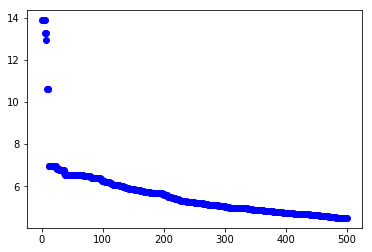

In [10]:
for i, row in enumerate(all_rsme_values,1):
    rsme_min = min(row)
    rsme_stdev = np.std(row)
    rsme_mean = np.mean(row)
    _ = plt.plot(i, rsme_min, 'bo')

## Test refactored version

In [11]:
from solvers.ea_solver import EASolver

In [12]:
solver = EASolver(X, pure_components, quadratic_correction)
solution, parameters = solver.solve(signal)

INFO:solvers.solver_interface:Solution updated: Round 0, RSME 51.223102587597296
INFO:solvers.solver_interface:Solution updated: Round 0, RSME 27.89854321334756
INFO:solvers.solver_interface:Solution updated: Round 0, RSME 25.392270951003685
INFO:solvers.solver_interface:Solution updated: Round 2, RSME 23.400902553223865
INFO:solvers.solver_interface:Solution updated: Round 3, RSME 15.054008147873567
INFO:solvers.solver_interface:Solution updated: Round 4, RSME 13.089135877128642
INFO:solvers.solver_interface:Solution updated: Round 4, RSME 8.717770124993493
INFO:solvers.solver_interface:Solution updated: Round 4, RSME 6.085804282998028
INFO:solvers.solver_interface:Solution updated: Round 6, RSME 3.768256253104914
INFO:solvers.solver_interface:Solution updated: Round 9, RSME 3.707555261958825
INFO:solvers.solver_interface:Solution updated: Round 10, RSME 3.6380697363827883
INFO:solvers.solver_interface:Solution updated: Round 13, RSME 3.4688643383857602
INFO:solvers.solver_interface:S

INFO:solvers.solver_interface:Solution updated: Round 184, RSME 1.5840392854310847
INFO:solvers.solver_interface:Solution updated: Round 189, RSME 1.5810381564242273
INFO:solvers.solver_interface:Solution updated: Round 191, RSME 1.5583347563438223
INFO:solvers.solver_interface:Solution updated: Round 192, RSME 1.5463744802401653
INFO:solvers.solver_interface:Solution updated: Round 194, RSME 1.5303348905670102
INFO:solvers.solver_interface:Solution updated: Round 195, RSME 1.5239365507681744
INFO:solvers.solver_interface:Solution updated: Round 197, RSME 1.5211962157166214
INFO:solvers.solver_interface:Solution updated: Round 200, RSME 1.5139820173825687
INFO:solvers.solver_interface:Solution updated: Round 200, RSME 1.512917849104187
INFO:solvers.solver_interface:Solution updated: Round 206, RSME 1.5061393650377497
INFO:solvers.solver_interface:Solution updated: Round 208, RSME 1.5059714250742913
INFO:solvers.solver_interface:Solution updated: Round 210, RSME 1.4837596175116297
INFO:

INFO:solvers.solver_interface:Solution updated: Round 375, RSME 1.1063208490519443
INFO:solvers.solver_interface:Solution updated: Round 377, RSME 1.1039804470236099
INFO:solvers.solver_interface:Solution updated: Round 378, RSME 1.1035495382815421
INFO:solvers.solver_interface:Solution updated: Round 381, RSME 1.1024722044489774
INFO:solvers.solver_interface:Solution updated: Round 384, RSME 1.1020955998254216
INFO:solvers.solver_interface:Solution updated: Round 386, RSME 1.0983376127722602
INFO:solvers.solver_interface:Solution updated: Round 387, RSME 1.0965948086293076
INFO:solvers.solver_interface:Solution updated: Round 388, RSME 1.0915953501964895
INFO:solvers.solver_interface:Solution updated: Round 393, RSME 1.0911524621319255
INFO:solvers.solver_interface:Solution updated: Round 394, RSME 1.0893783756383026
INFO:solvers.solver_interface:Solution updated: Round 395, RSME 1.0862656765578969
INFO:solvers.solver_interface:Solution updated: Round 396, RSME 1.0853303143973976
INFO